In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [10]:
num_classes = 3
image_dimension = 300
batch_size = 16
model_name = "rps_cnn_1"

In [11]:
TRAIN_DIR = os.getcwd() + "/dataset/rps/"
VALIDATION_DIR = os.getcwd() + "/dataset/rps-test-set/"

In [12]:
TRAIN_DIR, VALIDATION_DIR

('/home/amogh/Documents/Study/PiRockPaperScissors/notebooks/dataset/rps/',
 '/home/amogh/Documents/Study/PiRockPaperScissors/notebooks/dataset/rps-test-set/')

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(image_dimension, image_dimension),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(image_dimension, image_dimension),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [8]:
model = Sequential()

model.add(
    Conv2D(
        64,
        (3, 3),
        padding="same",
        input_shape=(image_dimension, image_dimension, 3),
        activation="relu",
    )
)
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 128)       0

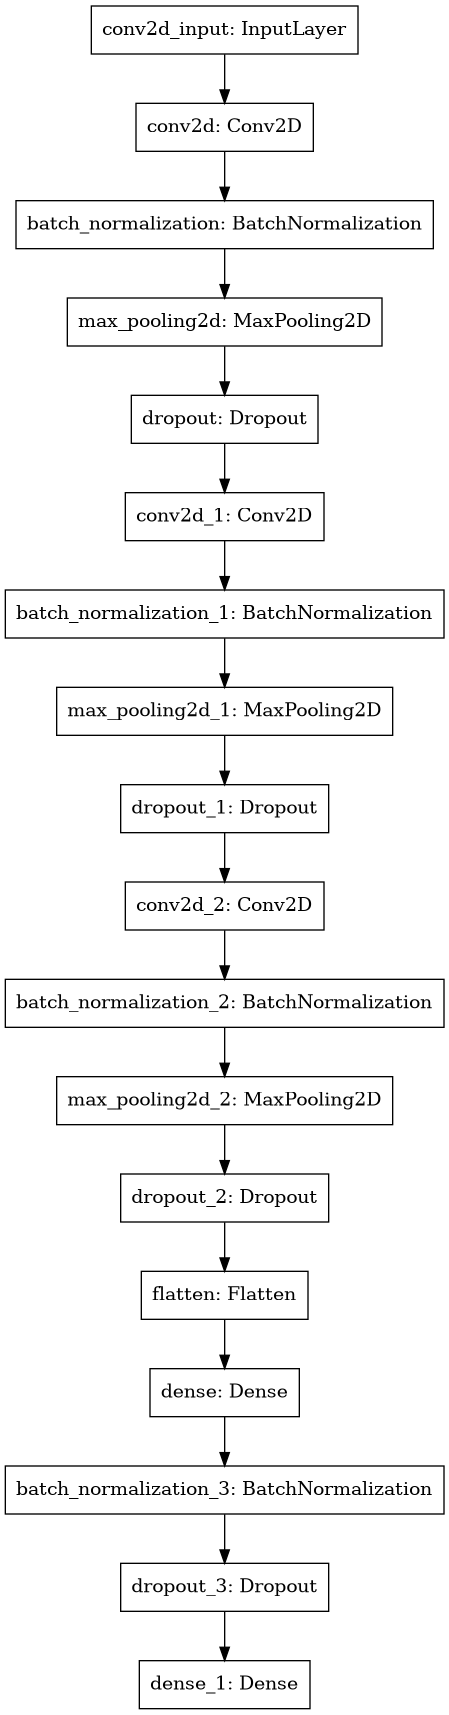

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [17]:
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

nb_train_samples = 2520
nb_validation_samples = 372
epochs = 50

In [11]:
checkpoint = ModelCheckpoint(
    os.getcwd() + "/models/{}.h5".format(model_name),
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="log_dir/{}".format(model_name), histogram_freq=1
)

callbacks = [earlystop, checkpoint, tensorboard_callback]

model.compile(
    loss="categorical_crossentropy", optimizer=RMSprop(lr=0.001), metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
)

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.5637 - accuracy: 0.4397
Epoch 00001: val_loss improved from inf to 15.10304, saving model to /home/amogh/Documents/Study/PiRockPaperScissors/notebooks/models/rps_cnn_1.h5
157/157 [==============================] - 47s 299ms/step - loss: 1.5637 - accuracy: 0.4397 - val_loss: 15.1030 - val_accuracy: 0.3261
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.8110 - accuracy: 0.6697
Epoch 00002: val_loss improved from 15.10304 to 5.94712, saving model to /home/amogh/Documents/Study/PiRockPaperScissors/notebooks/models/rps_cnn_1.h5
157/157 [==============================] - 46s 291ms/step - loss: 0.8110 - accuracy: 0.6697 - val_loss: 5.9471 - val_accuracy: 0.3261
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7971
Epoch 00003: val_loss improved from 5.94712 to 3.45717, saving model to /home/amogh/Documents/Study/PiRockPaperScissors/notebooks/models/rps_cnn_

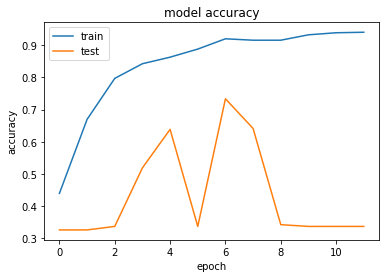

In [12]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

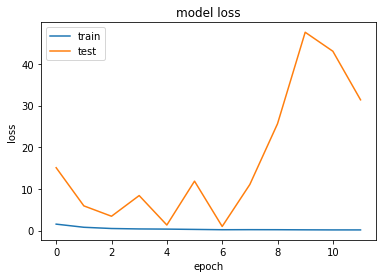

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model(os.getcwd() + "/models/{}.h5".format(model_name))

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Confution Matrix and Classification Report
Y_pred = loaded_model.predict_generator(
    validation_generator, nb_validation_samples // batch_size + 1
)
y_pred = np.argmax(Y_pred, axis=1)

class_labels = {v: k for k, v in validation_generator.class_indices.items()}

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print("Classification Report")
target_names = list(class_labels.values())
print(
    classification_report(
        validation_generator.classes, y_pred, target_names=target_names
    )
)

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[119   0   5]
 [ 13 101  10]
 [ 74   0  50]]
Classification Report
              precision    recall  f1-score   support

       paper       0.58      0.96      0.72       124
        rock       1.00      0.81      0.90       124
    scissors       0.77      0.40      0.53       124

    accuracy                           0.73       372
   macro avg       0.78      0.73      0.72       372
weighted avg       0.78      0.73      0.72       372



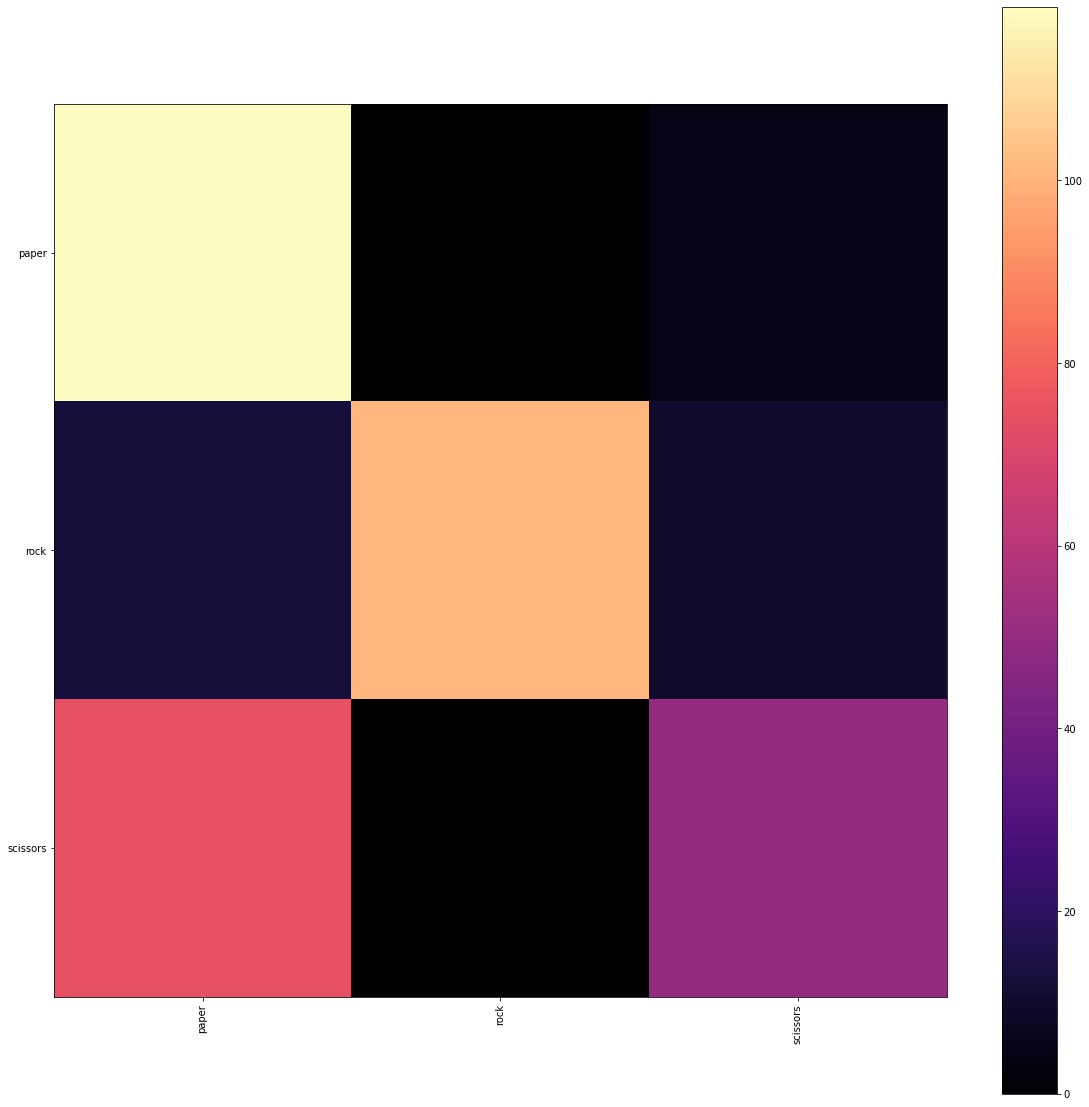

In [19]:
plt.figure(figsize=(20, 20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.imshow(cnf_matrix, interpolation="nearest", cmap="magma")
plt.colorbar()

classes = list(class_labels.values())

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [20]:
from os import listdir
from tensorflow.keras.preprocessing import image

path = VALIDATION_DIR

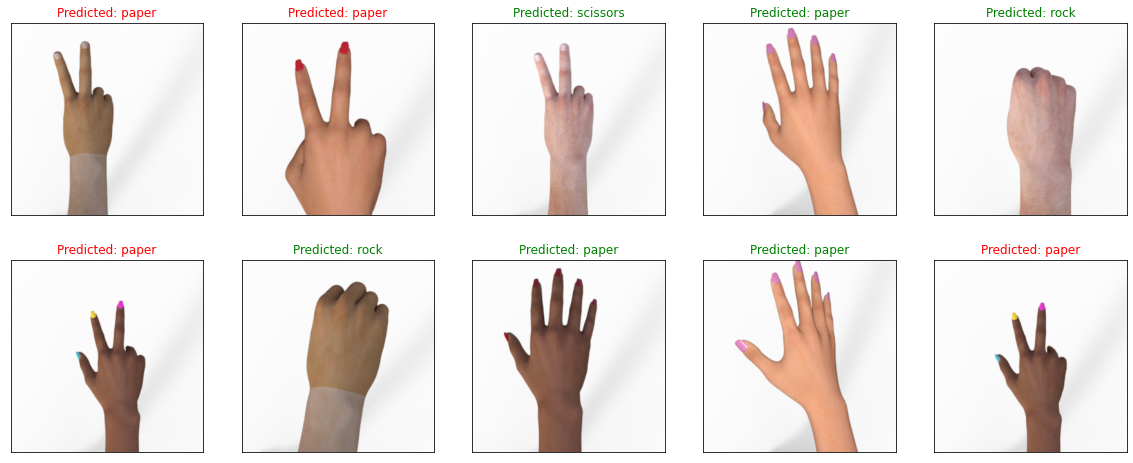

In [25]:
fig = plt.figure(figsize=(20, 8))


def predictedLabelColor(original, predicted):
    if original == predicted:
        return "green"
    else:
        return "red"


for i in range(10):
    rps_names = os.listdir(path)
    rps_names_folders = os.listdir(path)
    random_rps_index = np.random.randint(0, len(rps_names))
    rps_name = rps_names_folders[random_rps_index]

    rps_images_path = path + "/" + rps_name
    rps_images = os.listdir(rps_images_path)
    random_rps_image_index = np.random.randint(0, len(rps_images))
    rps_image = rps_images[random_rps_image_index]
    rps_image_path = rps_images_path + "/" + rps_image

    result_image_array = image.img_to_array(
        image.load_img(
            rps_image_path, target_size=(image_dimension, image_dimension)
        )
    )
    normalized_result = result_image_array * 1.0 / 255
    expanded_result = np.expand_dims(normalized_result, axis=0)
    classes = loaded_model.predict_classes(expanded_result, batch_size=10)
    predicted_label = class_labels[classes[0]]

    # plt.imshow(image.load_img(rps_image_path, target_size = (image_dimension, image_dimension)))
    # plt.xlabel('Original: {}, Predicted: {}'.format(rps_name, predicted_label))

    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(
        "Predicted: {}".format(predicted_label),
        color=predictedLabelColor(rps_name, predicted_label),
    )
    plt.imshow(normalized_result)

plt.show()